In [1]:
# Titanic Kaggle Competition – Exploration and XGBoost
# Andrew Plunket
# http://aplunket.com/titanic-kaggle-xgboost/

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn import metrics, model_selection
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier

In [3]:
figsize = (12, 8)
sns.set(style='white', font_scale=0.9)

In [4]:
survived_str = "Survived"
unknown_str = "Unknown"

### data

In [5]:
df_train = pd.read_csv('titanic_train.csv')
df_test = pd.read_csv('titanic_test.csv')
df_total = df_train.append(df_test)

In [6]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


### survival by passenger class

In [9]:
grouped_by_pclass = df_train.groupby('Pclass')

In [10]:
grouped_by_pclass_survived_means = grouped_by_pclass[survived_str].mean()
grouped_by_pclass_survived_means

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

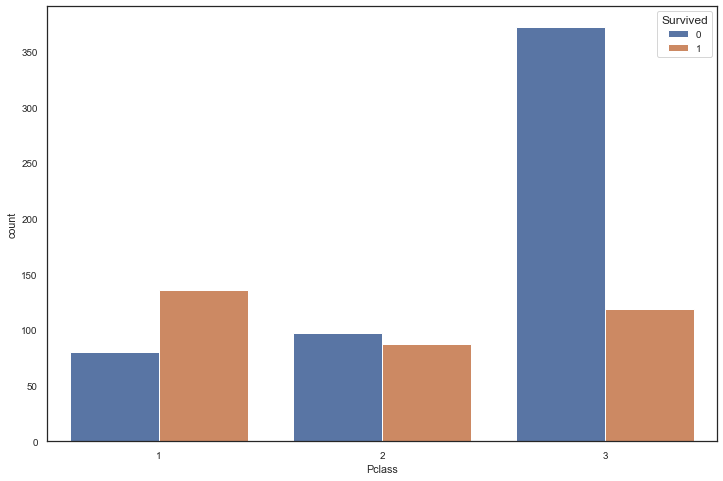

In [11]:
plt.figure(figsize=figsize)
sns.countplot(x='Pclass', data=df_train, hue='Survived', palette='deep')
plt.show()

### survival by title

In [12]:
def extract_title_from_name(names):
    last_name_and_titles = names.str.split(".").str[0]
    titles = last_name_and_titles.str.split(" ").str[-1]
    return titles

In [13]:
df_train['Title'] = extract_title_from_name(df_train['Name'])
df_test['Title'] = extract_title_from_name(df_test['Name'])
df_train.drop('Name', axis=1, inplace=True)
df_test.drop('Name', axis=1, inplace=True)
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [14]:
def update_title(title):
    if title in ['Mlle', 'Ms', 'Mme']:
        return 'Miss'
    elif title in ['Mr', 'Miss', 'Mrs', 'Master']:
        return title
    else:
        return 'Other'

In [15]:
df_train['Title'] = df_train['Title'].apply(lambda x: update_title(x))
df_test['Title'] = df_test['Title'].apply(lambda x: update_title(x))

In [16]:
df_train['Title'].value_counts()

Mr        517
Miss      186
Mrs       125
Master     40
Other      23
Name: Title, dtype: int64

In [17]:
df_test['Title'].value_counts()

Mr        240
Miss       79
Mrs        72
Master     21
Other       6
Name: Title, dtype: int64

In [18]:
mask_0 = df_train[survived_str] == 0
mask_1 = df_train[survived_str] == 1

In [19]:
n_survived_0 = sum(mask_0)
n_survived_1 = sum(mask_1)
n_survived_0, n_survived_1

(549, 342)

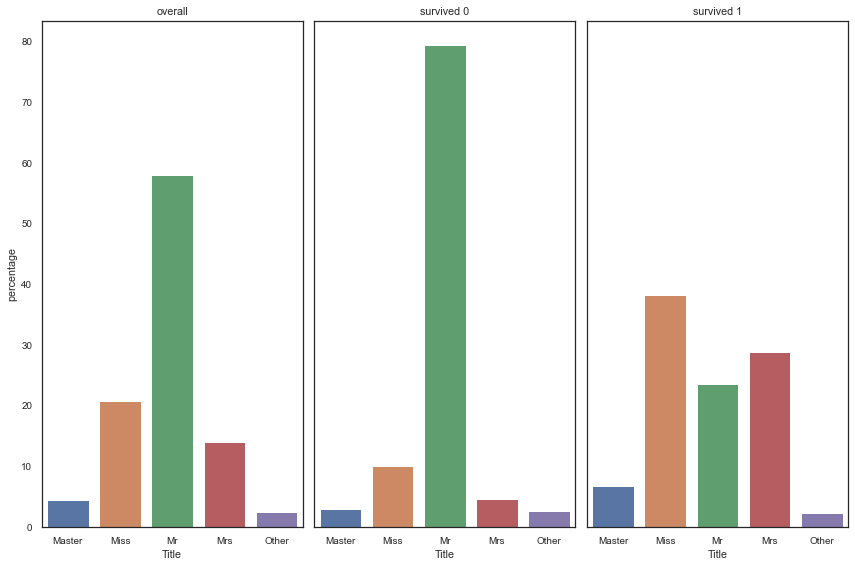

In [20]:
f, (ax_0, ax_1, ax_2) = plt.subplots(1, 3, sharey=True, figsize=figsize)

sns.barplot(x='Title', y='PassengerId', data=df_train,
            estimator=lambda x: len(x) / (n_survived_0 + n_survived_1) * 100,
            ax=ax_0, order=sorted(df_train['Title'].unique()), palette='deep')

sns.barplot(x='Title', y='PassengerId', data=df_train[mask_0],
            estimator=lambda x: len(x) / n_survived_0 * 100,
            ax=ax_1, order=sorted(df_train['Title'].unique()), palette='deep')

sns.barplot(x='Title', y='PassengerId', data=df_train[mask_1],
            estimator=lambda x: len(x) / n_survived_1 * 100,
            ax=ax_2, order=sorted(df_train['Title'].unique()), palette='deep')

ax_0.set_title('overall')
ax_1.set_title('survived 0')
ax_2.set_title('survived 1')
ax_0.set_ylabel('percentage')
ax_1.set_ylabel('')
ax_2.set_ylabel('')
plt.tight_layout()
plt.show()

### sex

In [21]:
grouped_by_sex = df_train.groupby('Sex')

In [22]:
grouped_by_sex_survived_means = grouped_by_sex[survived_str].mean()
grouped_by_sex_survived_means

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

### survival by age

In [23]:
# fill missing age with average age
average_age = df_total['Age'].mean()

df_train['Age'] = df_train['Age'].fillna(average_age)
df_test['Age'] = df_test['Age'].fillna(average_age)

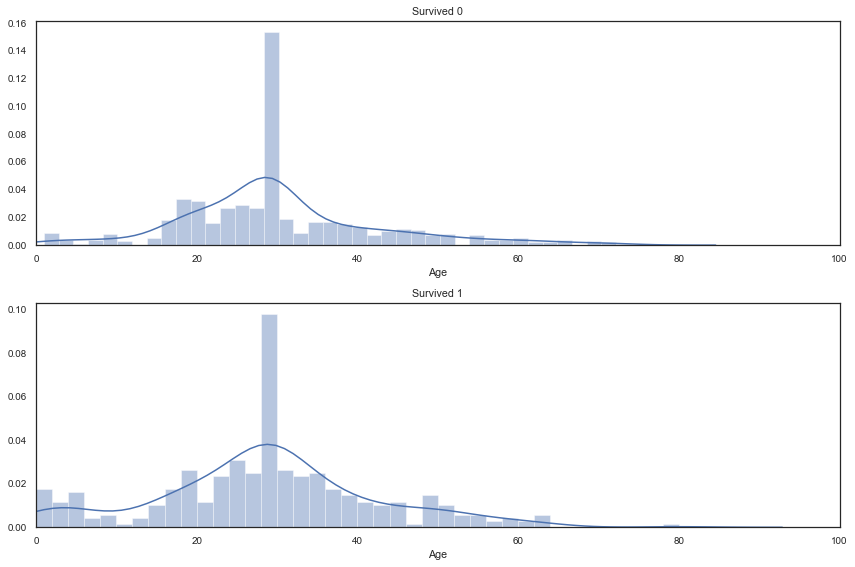

In [24]:
# plot distribution of age by survival
f, (ax_0, ax_1) = plt.subplots(2, 1, figsize=figsize)
sns.distplot(df_train[mask_0]['Age'].astype(int), bins=40, ax=ax_0, kde=True)
sns.distplot(df_train[mask_1]['Age'].astype(int), bins=40, ax=ax_1, kde=True)
ax_0.set_title(f"{survived_str} 0")
ax_1.set_title(f"{survived_str} 1")
ax_0.set_xbound(lower=0, upper=100)
ax_1.set_xbound(lower=0, upper=100)
plt.tight_layout()
plt.show()

### survival by sibling, spouse

In [25]:
df_train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [26]:
grouped_by_sibsp = df_train.groupby('SibSp')

In [27]:
grouped_by_sibsp[survived_str].mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

### survival by children, parents

In [28]:
df_train['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [29]:
grouped_by_parch = df_train.groupby('Parch')

In [30]:
grouped_by_parch[survived_str].mean()

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

### survival by sibling, spouce, children, parents

In [31]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] 
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] 
df_train.drop('SibSp', axis=1, inplace=True)
df_test.drop('SibSp', axis=1, inplace=True)
df_train.drop('Parch', axis=1, inplace=True)
df_test.drop('Parch', axis=1, inplace=True)
df_train['FamilySize'] = df_train['FamilySize'].apply(lambda x: 4 if x > 4 else x)
df_test['FamilySize'] = df_test['FamilySize'].apply(lambda x: 4 if x > 4 else x)

In [32]:
grouped_by_family_size = df_train.groupby('FamilySize')

In [33]:
grouped_by_family_size[survived_str].mean()

FamilySize
0    0.303538
1    0.552795
2    0.578431
3    0.724138
4    0.161290
Name: Survived, dtype: float64

### survival by ticket

In [34]:
# replace ticket value with its first character
df_train['Ticket'] = df_train['Ticket'].str[:1]
df_test['Ticket'] = df_train['Ticket'].str[:1]

In [35]:
grouped_by_ticket = df_train.groupby('Ticket')

In [36]:
grouped_by_ticket[survived_str].mean()

Ticket
1    0.630137
2    0.464481
3    0.239203
4    0.200000
5    0.000000
6    0.166667
7    0.111111
8    0.000000
9    1.000000
A    0.068966
C    0.340426
F    0.571429
L    0.250000
P    0.646154
S    0.323077
W    0.153846
Name: Survived, dtype: float64

In [37]:
# fill missing fare with average fare
average_fare = df_total['Fare'].mean()

df_train['Fare'] = df_train['Fare'].fillna(average_fare)
df_test['Fare'] = df_test['Fare'].fillna(average_fare)

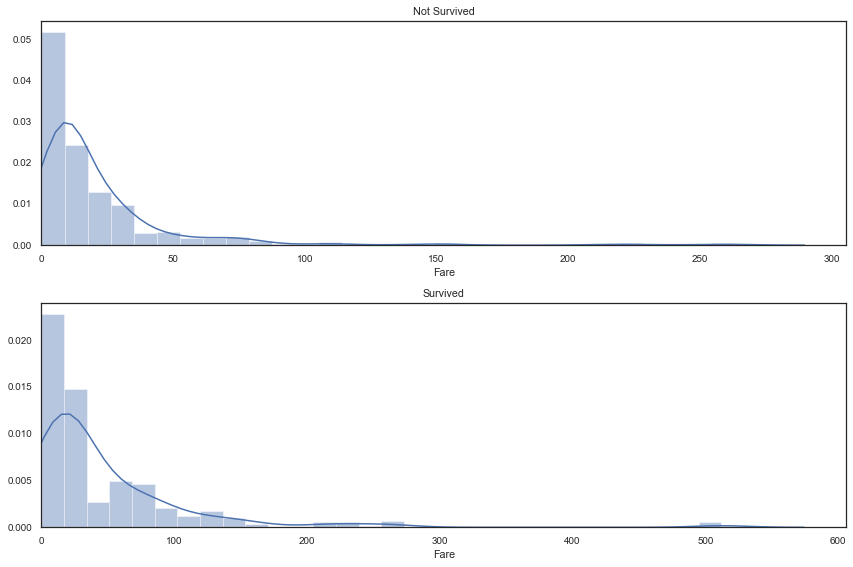

In [38]:
# plot distribution of fare by survival
f, (ax_0, ax_1) = plt.subplots(2, 1, figsize=figsize)
sns.distplot(df_train[mask_0]['Fare'].astype(int), bins=30, ax=ax_0, kde=True)
sns.distplot(df_train[mask_1]['Fare'].astype(int), bins=30, ax=ax_1, kde=True)

ax_0.set_title(f"Not {survived_str}")
ax_1.set_title(survived_str)
ax_0.set_xbound(lower=0)
ax_1.set_xbound(lower=0)
plt.tight_layout()
plt.show()

In [39]:
grouped_by_survived = df_train.groupby(survived_str)

In [40]:
grouped_by_survived['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,549.0,22.117887,31.388207,0.0,7.8542,10.5,26.0,263.0000
1,342.0,48.395408,66.596998,0.0,12.4750,26.0,57.0,512.3292


### survival by cabin

In [41]:
# replace cabin value with its first character
df_train['Cabin'] = df_train['Cabin'].str[0]
df_test['Cabin'] = df_test['Cabin'].str[0]

In [42]:
# fill missing fare with "Unknown"
df_train['Cabin'] = df_train['Cabin'].fillna(unknown_str)
df_test['Cabin'] = df_test['Cabin'].fillna(unknown_str)

In [43]:
df_train['Cabin'].value_counts()

Unknown    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: Cabin, dtype: int64

In [44]:
grouped_by_cabin = df_train.groupby('Cabin')

In [45]:
grouped_by_cabin[survived_str].mean()

Cabin
A          0.466667
B          0.744681
C          0.593220
D          0.757576
E          0.750000
F          0.615385
G          0.500000
T          0.000000
Unknown    0.299854
Name: Survived, dtype: float64

### survival by Embarked

In [46]:
# fill missing Embarked with "Unknown"
df_train['Embarked'] = df_train['Embarked'].fillna(survived_str)
df_test['Embarked'] = df_test['Embarked'].fillna(survived_str)

In [47]:
df_train['Embarked'].value_counts()

S           644
C           168
Q            77
Survived      2
Name: Embarked, dtype: int64

In [48]:
grouped_by_embarked = df_train.groupby('Embarked')

In [49]:
grouped_by_embarked['Survived'].mean()

Embarked
C           0.553571
Q           0.389610
S           0.336957
Survived    1.000000
Name: Survived, dtype: float64

### review

In [50]:
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,1,0,3,male,22.0,A,7.2500,Unknown,S,Mr,1
1,2,1,1,female,38.0,P,71.2833,C,C,Mrs,1
2,3,1,3,female,26.0,S,7.9250,Unknown,S,Miss,0
3,4,1,1,female,35.0,1,53.1000,C,S,Mrs,1
4,5,0,3,male,35.0,3,8.0500,Unknown,S,Mr,0


In [51]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   Ticket       891 non-null    object 
 6   Fare         891 non-null    float64
 7   Cabin        891 non-null    object 
 8   Embarked     891 non-null    object 
 9   Title        891 non-null    object 
 10  FamilySize   891 non-null    int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [52]:
df_test.head()

,PassengerId,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,892,3,male,34.5,A,7.8292,Unknown,Q,Mr,0
1,893,3,female,47.0,P,7.0000,Unknown,S,Mrs,1
2,894,2,male,62.0,S,9.6875,Unknown,Q,Mr,0
3,895,3,male,27.0,1,8.6625,Unknown,S,Mr,0
4,896,3,female,22.0,3,12.2875,Unknown,S,Mrs,2


In [53]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    object 
 3   Age          418 non-null    float64
 4   Ticket       418 non-null    object 
 5   Fare         418 non-null    float64
 6   Cabin        418 non-null    object 
 7   Embarked     418 non-null    object 
 8   Title        418 non-null    object 
 9   FamilySize   418 non-null    int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 32.8+ KB


In [54]:
df_train_comb = df_train
df_train_comb['TrainTest'] = 'Train'
df_train_comb.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,FamilySize,TrainTest
0,1,0,3,male,22.0,A,7.2500,Unknown,S,Mr,1,Train
1,2,1,1,female,38.0,P,71.2833,C,C,Mrs,1,Train
2,3,1,3,female,26.0,S,7.9250,Unknown,S,Miss,0,Train
3,4,1,1,female,35.0,1,53.1000,C,S,Mrs,1,Train
4,5,0,3,male,35.0,3,8.0500,Unknown,S,Mr,0,Train


In [55]:
df_test_comb = df_test
df_test_comb['TrainTest'] = 'Test'
df_test_comb.head()

,PassengerId,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,FamilySize,TrainTest
0,892,3,male,34.5,A,7.8292,Unknown,Q,Mr,0,Test
1,893,3,female,47.0,P,7.0000,Unknown,S,Mrs,1,Test
2,894,2,male,62.0,S,9.6875,Unknown,Q,Mr,0,Test
3,895,3,male,27.0,1,8.6625,Unknown,S,Mr,0,Test
4,896,3,female,22.0,3,12.2875,Unknown,S,Mrs,2,Test


In [56]:
df_total = df_train_comb.append(df_test_comb)
df_total = pd.get_dummies(df_total, drop_first=True)

In [57]:
df_total.head()

,PassengerId,Survived,Pclass,Age,Fare,FamilySize,Sex_male,Ticket_2,Ticket_3,Ticket_4,...,Cabin_T,Cabin_Unknown,Embarked_Q,Embarked_S,Embarked_Survived,Title_Miss,Title_Mr,Title_Mrs,Title_Other,TrainTest_Train
0,1,0.0,3,22.0,7.2500,1,1,0,0,0,...,0,1,0,1,0,0,1,0,0,1
1,2,1.0,1,38.0,71.2833,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,3,1.0,3,26.0,7.9250,0,0,0,0,0,...,0,1,0,1,0,1,0,0,0,1
3,4,1.0,1,35.0,53.1000,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
4,5,0.0,3,35.0,8.0500,0,1,0,1,0,...,0,1,0,1,0,0,1,0,0,1


In [58]:
df_total.tail()

,PassengerId,Survived,Pclass,Age,Fare,FamilySize,Sex_male,Ticket_2,Ticket_3,Ticket_4,...,Cabin_T,Cabin_Unknown,Embarked_Q,Embarked_S,Embarked_Survived,Title_Miss,Title_Mr,Title_Mrs,Title_Other,TrainTest_Train
413,1305,NaN,3,29.881138,8.0500,0,1,1,0,0,...,0,1,0,1,0,0,1,0,0,0
414,1306,NaN,1,39.000000,108.9000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
415,1307,NaN,3,38.500000,7.2500,0,1,0,1,0,...,0,1,0,1,0,0,1,0,0,0
416,1308,NaN,3,29.881138,8.0500,0,1,1,0,0,...,0,1,0,1,0,0,1,0,0,0
417,1309,NaN,3,29.881138,22.3583,2,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [59]:
mask_train = df_total['TrainTest_Train'] == 1

In [60]:
X_train = df_total[mask_train]
X_train.drop(['Survived', 'PassengerId'], axis=1, inplace=True)
X_train.head()

/Users/dnguyen/Dev/practices/env/lib/python3.7/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Pclass,Age,Fare,FamilySize,Sex_male,Ticket_2,Ticket_3,Ticket_4,Ticket_5,Ticket_6,...,Cabin_T,Cabin_Unknown,Embarked_Q,Embarked_S,Embarked_Survived,Title_Miss,Title_Mr,Title_Mrs,Title_Other,TrainTest_Train
0,3,22.0,7.2500,1,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,1
1,1,38.0,71.2833,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,3,26.0,7.9250,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,0,1
3,1,35.0,53.1000,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
4,3,35.0,8.0500,0,1,0,1,0,0,0,...,0,1,0,1,0,0,1,0,0,1


In [61]:
Y_train = df_total[mask_train]['Survived']
Y_train.head()

0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: Survived, dtype: float64

In [62]:
mask_test = df_total['TrainTest_Train'] == 0

In [63]:
X_test = df_total[mask_test]
X_test.drop(['Survived', 'PassengerId'], axis=1, inplace=True)
X_test.head()

/Users/dnguyen/Dev/practices/env/lib/python3.7/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Pclass,Age,Fare,FamilySize,Sex_male,Ticket_2,Ticket_3,Ticket_4,Ticket_5,Ticket_6,...,Cabin_T,Cabin_Unknown,Embarked_Q,Embarked_S,Embarked_Survived,Title_Miss,Title_Mr,Title_Mrs,Title_Other,TrainTest_Train
0,3,34.5,7.8292,0,1,0,0,0,0,0,...,0,1,1,0,0,0,1,0,0,0
1,3,47.0,7.0000,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
2,2,62.0,9.6875,0,1,0,0,0,0,0,...,0,1,1,0,0,0,1,0,0,0
3,3,27.0,8.6625,0,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
4,3,22.0,12.2875,2,0,0,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0


### training XGboost models

In [64]:
learning_rate = 0.1
n_estimators = 140
max_depth = 5
min_child_weight = 1
gamma = 0
subsample = 0.8
colsample_bytree = 0.8
objective = "binary:logistic"
nthread = 4
scale_pos_weight = 1
seed = 0

model_0 = XGBClassifier(learning_rate=learning_rate, 
                        n_estimators=n_estimators, 
                        max_depth=max_depth,
                        min_child_weight=min_child_weight, 
                        gamma=gamma, 
                        subsample=subsample, 
                        colsample_bytree=colsample_bytree,
                        objective=objective, 
                        nthread=nthread, 
                        scale_pos_weight=scale_pos_weight, 
                        seed=seed)

In [65]:
param_grid_0 = {'max_depth': range(3, 10, 1),
                'min_child_weight': range(1, 6, 1)}

grid_0 = GridSearchCV(estimator=model_0, param_grid=param_grid_0, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_0.fit(X_train, Y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    7.1s finished


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=5, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=0, subsample=0.8,
                                     tree_method=None, validate_param

In [66]:
print(grid_0.best_score_)
print(grid_0.best_params_)

0.8812855093083396
{'max_depth': 9, 'min_child_weight': 5}


In [67]:
max_depth = 4
min_child_weight = 5
model_1 = XGBClassifier(learning_rate=learning_rate, 
                        n_estimators=n_estimators, 
                        max_depth=max_depth,
                        min_child_weight=min_child_weight, 
                        gamma=gamma, 
                        subsample=subsample, 
                        colsample_bytree=colsample_bytree,
                        objective=objective, 
                        nthread=nthread, 
                        scale_pos_weight=scale_pos_weight, 
                        seed=seed)

In [68]:
param_grid_1 = {'gamma': [i / 10 for i in range(0, 7)]}

grid_1 = GridSearchCV(estimator=model_1, param_grid=param_grid_1, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_1.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.9s finished


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=4, min_child_weight=5,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=0, subsample=0.8,
                                     tree_method=None, validate_param

In [69]:
print(grid_1.best_score_)
print(grid_1.best_params_)

0.8782663622072102
{'gamma': 0.5}


In [70]:
model_2 = XGBClassifier(learning_rate=learning_rate, 
                        n_estimators=n_estimators, 
                        max_depth=max_depth,
                        min_child_weight=min_child_weight, 
                        gamma=gamma, 
                        subsample=subsample, 
                        colsample_bytree=colsample_bytree,
                        objective=objective, 
                        nthread=nthread, 
                        scale_pos_weight=scale_pos_weight, 
                        seed=seed)

In [71]:
param_grid_2 = {'subsample': [i / 100.0 for i in range(60, 100, 5)],
                'colsample_bytree': [i / 100.0 for i in range(60, 100, 5)]}

grid_2 = model_selection.GridSearchCV(estimator=model_2, param_grid=param_grid_2, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_2.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    7.6s finished


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=4, min_child_weight=5,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=0, subsample=0.8,
                                     tree_method=None, validate_param

In [72]:
print(grid_2.best_score_)
print(grid_2.best_params_)

0.8825423608903981
{'colsample_bytree': 0.75, 'subsample': 0.95}


In [73]:
colsample_bytree = 0.95

model_3 = XGBClassifier(learning_rate=learning_rate, 
                        n_estimators=n_estimators, 
                        max_depth=max_depth,
                        min_child_weight=min_child_weight, 
                        gamma=gamma, 
                        subsample=subsample, 
                        colsample_bytree=colsample_bytree,
                        objective=objective, 
                        nthread=nthread, 
                        scale_pos_weight=scale_pos_weight, 
                        seed=seed)

In [74]:
param_grid_3 = {'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]}

grid_3 = model_selection.GridSearchCV(estimator=model_3, param_grid=param_grid_3, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_3.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.7s finished


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.95, gamma=0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=4, min_child_weight=5,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=140, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=0, subsample=0.8,
                                     tree_method=None, validate_para

In [75]:
print(grid_3.best_score_)
print(grid_3.best_params_)

0.879938245994993
{'reg_alpha': 0.1}


In [76]:
learning_rate = 0.01
n_estimators = 5000
reg_alpha = 1e-05

model = XGBClassifier(learning_rate=learning_rate, 
                      n_estimators=n_estimators, 
                      max_depth=max_depth,
                      min_child_weight=min_child_weight, 
                      gamma=gamma, 
                      subsample=subsample, 
                      colsample_bytree=colsample_bytree,
                      reg_alpha=reg_alpha,
                      objective=objective, 
                      nthread=nthread, 
                      scale_pos_weight=scale_pos_weight, 
                      seed=seed)

In [77]:
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.95, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=5000, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=0, reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1,
              seed=0, subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

### feature importance

In [78]:
feature_importance = pd.DataFrame.from_dict(model.get_booster().get_fscore(), orient='index')
feature_importance.head()

,0
Title_Mr,1091
Pclass,1043
Sex_male,911
FamilySize,1695
Fare,13452


In [79]:
feature_importance.columns = ['values']
feature_importance.sort_values(['values'], ascending=False, inplace=True)
feature_importance.reset_index(level=0, inplace=True)

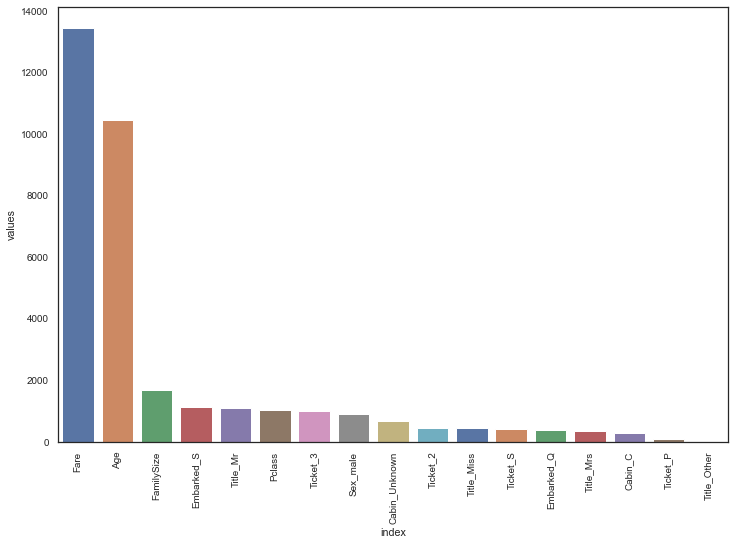

In [80]:
plt.figure(figsize=figsize)
sns.barplot(x='index', y='values', data=feature_importance, palette='deep')
plt.xticks(rotation=90)
plt.show()

In [81]:
Y_pred = model.predict(X_test)

In [82]:
Y_pred[:10]

array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0.])